# Trends in Beer Preferences
This dataset contains around 1.5 Millions reviews of beer scrapped from [BeerAdvocates](https://www.beeradvocate.com/)). Your goal is to characterize the dataset, group similar beers toghether and beeing able to recomend a beer in each group. Some driving questions you could try to answer using the data: If you had to pick 5 beers to recommend, which would you pick? Why? Which of the factors (taste, aroma, appearance, palate) are most important in determining the overall quality of a beer? If I usually enjoy IPAs, which beer should I try?

# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing as pre
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram

%matplotlib inline

In [2]:
pd.options.display.float_format = '{:.2f}'.format

# Data Import

In [3]:

# Import and combine files
beer_reviews_1 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_1.csv")
beer_reviews_2 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_2.csv")
df_beer_reviews = pd.concat([beer_reviews_1,beer_reviews_2])

In [4]:
# Shape
df_beer_reviews.shape

(1586614, 13)

In [5]:
df_beer_reviews.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986
1,10325,Vecchio Birraio,1235915097,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213
2,10325,Vecchio Birraio,1235916604,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215
3,10325,Vecchio Birraio,1234725145,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969
4,1075,Caldera Brewing Company,1293735206,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883


In [6]:
df_beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586614 entries, 0 to 714712
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 169.5+ MB


Looks like there are null values.  Let's take those out.

In [7]:
df_beer_reviews.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

First, impute beer_abv by using the average abv for its style.

In [8]:
mean_abv = df_beer_reviews.groupby('beer_style')['beer_abv'].transform('mean')
df_beer_reviews['beer_abv'] = df_beer_reviews['beer_abv'].fillna(mean_abv)

Brewery Name anf Profile name are fairly small.  Lets remove those. 

In [9]:
df_beer_reviews = df_beer_reviews.dropna()

Remove any duplicates

In [10]:
df_beer_reviews = df_beer_reviews.drop_duplicates()
df_beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586251 entries, 0 to 714712
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586251 non-null  int64  
 1   brewery_name        1586251 non-null  object 
 2   review_time         1586251 non-null  int64  
 3   review_overall      1586251 non-null  float64
 4   review_aroma        1586251 non-null  float64
 5   review_appearance   1586251 non-null  float64
 6   review_profilename  1586251 non-null  object 
 7   beer_style          1586251 non-null  object 
 8   review_palate       1586251 non-null  float64
 9   review_taste        1586251 non-null  float64
 10  beer_name           1586251 non-null  object 
 11  beer_abv            1586251 non-null  float64
 12  beer_beerid         1586251 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 169.4+ MB


Next let's look at the data.   


In [11]:
df_beer_reviews.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986
1,10325,Vecchio Birraio,1235915097,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213
2,10325,Vecchio Birraio,1235916604,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215
3,10325,Vecchio Birraio,1234725145,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969
4,1075,Caldera Brewing Company,1293735206,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883


In [12]:
df_beer_reviews.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00
mean,3130.38,1224099824.45,3.82,3.74,3.84,3.74,3.79,7.00,21714.68
std,5578.48,76544129.66,0.72,0.70,0.62,0.68,0.73,2.30,21819.01
min,1.00,840672001.00,0.00,1.00,0.00,1.00,1.00,0.01,3.00
25%,143.00,1173235589.50,3.50,3.50,3.50,3.50,3.50,5.20,1717.00
50%,429.00,1239222229.00,4.00,4.00,4.00,4.00,4.00,6.50,13906.00
75%,2372.00,1288571868.50,4.50,4.00,4.00,4.00,4.50,8.50,39441.00
max,28003.00,1326285348.00,5.00,5.00,5.00,5.00,5.00,57.70,77317.00


Things to Note
- brewery_id associated with brewery_name
- beer-name associated with beer_id
- review-time will need to be converted
- reviews are on 0-5 scale

Let's covert the timestamp

In [13]:
from datetime import date
df_beer_reviews['review_time'] = [date.fromtimestamp(x) for x in df_beer_reviews['review_time']]
df_beer_reviews['review_time'] = pd.to_datetime(df_beer_reviews['review_time'] )

In [14]:
df_beer_reviews.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986
1,10325,Vecchio Birraio,2009-03-01,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213
2,10325,Vecchio Birraio,2009-03-01,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215
3,10325,Vecchio Birraio,2009-02-15,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969
4,1075,Caldera Brewing Company,2010-12-30,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883


Let's look at the number of unique values for the different categorical Values

In [15]:
# Unique 
print('Number of Breweries (ID): ', df_beer_reviews['brewery_id'].nunique())
print('Number of Breweries (Name): ', df_beer_reviews['brewery_name'].nunique())
print('Number of Reviewers: ', df_beer_reviews['review_profilename'].nunique())
print('Number of Beer Styles: ', df_beer_reviews['beer_style'].nunique())
print('Number of Beers: (ID)', df_beer_reviews['beer_beerid'].nunique())
print('Number of Beers: (Name)', df_beer_reviews['beer_name'].nunique())

Number of Breweries (ID):  5838
Number of Breweries (Name):  5742
Number of Reviewers:  33387
Number of Beer Styles:  104
Number of Beers: (ID) 66040
Number of Beers: (Name) 56847


Multiple Breweries with duplicate names.
Multiple Beers with duplicate names

In [16]:
df_group_breweries_id = df_beer_reviews[['brewery_name','brewery_id']].drop_duplicates()
df_group_breweries_id.groupby('brewery_name').agg({'brewery_id':'count'}).sort_values(by='brewery_id',ascending=False)

,brewery_id
brewery_name,
Ram Restaurant & Brewery,8
Hops Grillhouse & Brewery,7
BJ's Restaurant & Brewery,4
Sierra Madre Brewing Co.,4
Hereford & Hops Restaurant & Brewpub,4
...,...
Den Engel Bierbrouwers,1
Dempsey's Restaurant And Brewery,1
"Dempsey's Brewery, Restaurant & Pub",1


In [17]:
df_group_breweries_id[df_group_breweries_id['brewery_name'] == 'Ram Restaurant & Brewery']

,brewery_name,brewery_id
9996,Ram Restaurant & Brewery,21590
554470,Ram Restaurant & Brewery,1455
826288,Ram Restaurant & Brewery,4069
848937,Ram Restaurant & Brewery,4978
383742,Ram Restaurant & Brewery,3964
503370,Ram Restaurant & Brewery,16413
534404,Ram Restaurant & Brewery,5439
560864,Ram Restaurant & Brewery,5191


After researching these breweries on the website,  The multiples represent different locations of breweries.  So I will pull these in 

#  Grab Location Data


In [18]:
from bs4 import BeautifulSoup
import urllib3
import re

In [19]:
# Scrapper using beer_id and brewery_id from Beer Advocate
def getLocationFromURL(id):
    # print(id)
    http = urllib3.PoolManager()
    url = 'https://www.beeradvocate.com/beer/profile/'+str(id)+'/'
    response = http.request('GET', url)
    soup = BeautifulSoup(response.data)
    location_box = soup.find('title')
    # print(location_box)
    try:
        x = str(location_box).split('|')[1].strip()
    except:
        x = 'ERROR: '+str(location_box)
    return x

In [20]:
# Create table of brewery_id to brewery location
#df_brewery_location = df_beer_reviews[['brewery_id']].copy()
#df_brewery_location = df_brewery_location.drop_duplicates()
#df_brewery_location['location'] = df_brewery_location['brewery_id'].apply(lambda x: getLocationFromURL(x))


In [21]:
#df_brewery_location.to_csv('./data/brewery_locations.csv')
df_brewery_location = pd.read_csv('./data/brewery_locations.csv')

In [22]:
# use NA for Locations with Errors
df_brewery_location['location'] = df_brewery_location['location'].replace({'ERROR: <title>404 Not Found - BeerAdvocate</title>':'NA, NA'})

In [23]:
df_brewery_location[df_brewery_location['location'].str.contains('NA')].count()

Unnamed: 0    15
brewery_id    15
location      15
dtype: int64

15 Unkown locations.  We will leave them for now

Let's split the location into City, State, Country

In [24]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

new = df_brewery_location['location'].str.split(',', n = 2, expand = True)
new[0] = new[0].str.strip()
new[1] = new[1].str.strip()
new[2] = new[2].str.strip()
new['country'] = new[1].apply(lambda x:x if x not in states else 'United States')
df_brewery_location['city'] = new[0]
df_brewery_location['state/province'] = new[1]
df_brewery_location['country'] = new['country']

In [25]:
df_brewery_location.head(5)

,Unnamed: 0,brewery_id,location,city,state/province,country
0,0,10325,"Marsango Di Campo San Martino (PD), Italy",Marsango Di Campo San Martino (PD),Italy,Italy
1,4,1075,"Ashland, OR",Ashland,OR,United States
2,10,163,"Amsterdam, Netherlands",Amsterdam,Netherlands,Netherlands
3,393,1454,"Indianapolis, IN",Indianapolis,IN,United States
4,403,850,"Savannah, GA",Savannah,GA,United States


In [26]:
df_beer_reviews = df_beer_reviews.merge(df_brewery_location, on='brewery_id')
df_beer_reviews = df_beer_reviews.drop(columns = 'Unnamed: 0')
df_beer_reviews.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,location,city,state/province,country
0,10325,Vecchio Birraio,2009-02-16,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986,"Marsango Di Campo San Martino (PD), Italy",Marsango Di Campo San Martino (PD),Italy,Italy
1,10325,Vecchio Birraio,2009-03-01,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213,"Marsango Di Campo San Martino (PD), Italy",Marsango Di Campo San Martino (PD),Italy,Italy
2,10325,Vecchio Birraio,2009-03-01,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215,"Marsango Di Campo San Martino (PD), Italy",Marsango Di Campo San Martino (PD),Italy,Italy
3,10325,Vecchio Birraio,2009-02-15,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969,"Marsango Di Campo San Martino (PD), Italy",Marsango Di Campo San Martino (PD),Italy,Italy
4,1075,Caldera Brewing Company,2010-12-30,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883,"Ashland, OR",Ashland,OR,United States


In [27]:
df_temp = df_beer_reviews[df_beer_reviews['country'] == 'NA']
df_temp['brewery_name'].drop_duplicates().to_list()

['Alcatraz Brewing Co.',
 'Port Brewing Company / Pizza Port',
 "John Harvard's Brewery & Ale House",
 'Tracks Brewpub (Duplicate)',
 'Goose Island Beer Co.',
 'Harpoon Brewery',
 'Little Yeoman Brewing Company (DUPLICATE)',
 'Beer Works',
 'Appalachian Brewing Company',
 'Dogfish Head Brewery',
 'Bare Bones Grill & Brewery',
 "Duncan's Founders Brewery",
 'Yuengling Brewery ']

In [28]:
missing_locations =['Alcatraz Brewing Co.',
 'Port Brewing Company / Pizza Port',
 "John Harvard's Brewery & Ale House",
 'Tracks Brewpub (Duplicate)',
 'Goose Island Beer Co.',
 'Harpoon Brewery',
 'Little Yeoman Brewing Company (DUPLICATE)',
 'Beer Works',
 'Appalachian Brewing Company',
 'Dogfish Head Brewery',
 'Bare Bones Grill & Brewery',
 "Duncan's Founders Brewery",
 'Yuengling Brewery ']

df_temp = df_beer_reviews[df_beer_reviews['brewery_name'].isin(missing_locations)]
df_temp[['brewery_name','brewery_id','location']].drop_duplicates()

,brewery_name,brewery_id,location
45030,Alcatraz Brewing Co.,1930,"NA, NA"
146152,Port Brewing Company / Pizza Port,5318,"NA, NA"
344662,John Harvard's Brewery & Ale House,1548,"NA, NA"
354551,Tracks Brewpub (Duplicate),3257,"NA, NA"
585464,Goose Island Beer Co.,1549,"NA, NA"
606681,Harpoon Brewery,10097,"NA, NA"
663681,Little Yeoman Brewing Company (DUPLICATE),5379,"NA, NA"
721489,Beer Works,9343,"NA, NA"
729145,Appalachian Brewing Company,18968,"NA, NA"
1157826,Dogfish Head Brewery,10099,"NA, NA"


In [29]:
missing_locations_dict = {'Alcatraz Brewing Co.' : ['Orange','CA','United States'],
                        'Port Brewing Company / Pizza Port': ['Carlsbad','CA','United States'],
                        "John Harvard's Brewery & Ale House": ['Framingham','MA','United States'],
                        'Tracks Brewpub (Duplicate)': ['Brampton','Ontario','Canada'],
                        'Goose Island Beer Co.': ['Chicago','IL','United States'],
                        'Harpoon Brewery': ['Boston','MA','United States'],
                        'Little Yeoman Brewing Company (DUPLICATE)': ['Cabool','MO','United States'],
                        'Beer Works': ['Boston','MA','United States'],
                        'Appalachian Brewing Company': ['Litiz','PA','United States'],
                        'Dogfish Head Brewery': ["Milton",'DE','United States'],
                        'Bare Bones Grill & Brewery': ['Ellicott City','MD','United States'],
                        "Duncan's Founders Brewery": ['Nelson','New Zealand','New Zealand'],
                        'Yuengling Brewery ': ['Pottsville','PA','United States']}

df_beer_reviews['city'] = df_beer_reviews.apply(lambda x: missing_locations_dict[x['brewery_name']][0] if x['brewery_name'] in missing_locations_dict else x['city'], axis=1)
df_beer_reviews['state/province'] = df_beer_reviews.apply(lambda x: missing_locations_dict[x['brewery_name']][1] if x['brewery_name'] in missing_locations_dict else x['state/province'], axis=1)
df_beer_reviews['country'] = df_beer_reviews.apply(lambda x: missing_locations_dict[x['brewery_name']][2] if x['brewery_name'] in missing_locations_dict else x['country'], axis=1)
df_beer_reviews['location'] = df_beer_reviews.apply(lambda x: ', '.join([missing_locations_dict[x['brewery_name']][0],missing_locations_dict[x['brewery_name']][1]]) if x['brewery_name'] in missing_locations_dict else x['location'], axis=1)



In [30]:
country_dict = {'AB': 'Canada',
  'BC': 'Canada',
  'GB2': 'England',
  'GB5': 'Northern Ireland',
  'GB6': 'Scotland',
  'GB7': 'Wales',
  'Gloucestershire': 'England',
  'Guernsey': 'England',
  'Hampshire': 'England',
  'Honiton': 'England',
  'Huddersfield': 'England',
  'Isle Of Lewis': 'Scotland',
  'Isle Of Wight': 'England',
  'Jilin Province': 'China',
  'Lancashire': 'England',
  'MB': 'Canada',
  'NB': 'Canada',
  'NL': 'Canada',
  'Norfolk': 'England',
  'Northumberland': 'England',
  'Nr. Huddersfield': 'England',
  'NS': 'Canada',
  'ON': 'Canada',
  'Oost-Vlaanderen': 'Belgium',
  'Oxfordshire': 'England',
  'PE': 'Canada',
  'Penzenskiy Oblast': 'Russia',
  'Pretoria': 'South Africa',
  'QC': 'Canada',
  'Renfrewshire': 'Scotland',
  'Rossshire': 'Scotland',
  'Salisbury': 'England',
  'Samara': 'Russia',
  'San Marino': 'Italy',
  'Saxony': 'Germany',
  'Shetland': 'Scotland',
  'SK': 'Canada',
  'Somerset': 'England',
  'South Yorkshire': 'England',
  'Staffordshire': 'England',
  'Suffolk': 'England',
  'Treviso': 'Italy',
  'Trinidad &amp; Tobago': 'Trinidad and Tobago',
  'Turks &amp; Caicos Islands': 'Turks and Caicos Islands',
  'Volgograd Oblast': 'Russia',
  'Wadebridge': 'England',
  'West Midlands': 'England',
  'West Yorkshire': 'England',
  'Weston Super Mare': 'England',
  'Wiltshire': 'England',
  'Xiangfang': 'China',
  'YT': 'Canada',
  'Bosnia &amp; Herzegovina': 'Bosnia and Herzegovina',
  'Saint Vincent &amp; The Grenadines': 'Saint Vincent and The Grenadines',
  'Antigua &amp; Barbuda': 'Antigua and Barbuda'}

df_beer_reviews['country'] = df_beer_reviews['country'].apply(lambda x: country_dict[x] if x in country_dict else x)

That does it for cleaning.  Let's begin Exploritory Analysis

# EDA

Looking at the statistics:


In [31]:
df_beer_reviews.shape

(1586251, 17)

In [32]:
# Revews by 
print('Number of Breweries: ', df_beer_reviews['brewery_id'].nunique())
print('Number of Reviewers: ', df_beer_reviews['review_profilename'].nunique())
print('Number of Beer Styles: ', df_beer_reviews['beer_style'].nunique())
print('Number of Beers:', df_beer_reviews['beer_beerid'].nunique())
print('Number of Cities:', df_beer_reviews['city'].nunique())


Number of Breweries:  5838
Number of Reviewers:  33387
Number of Beer Styles:  104
Number of Beers: 66040
Number of Cities: 3799


## Reviewers

In [33]:
col_descrip = ['review_profilename']
df_groupby_reviewers = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : 'mean',
                                                            'review_taste' : 'mean',
                                                            'review_palate' : 'mean',
                                                            'review_aroma' : 'mean',
                                                            'review_appearance': 'mean',
                                                            'beer_beerid' : 'count'}).reset_index().rename( columns = { 'beer_beerid' : 'number_of_reviews' } )
df_groupby_reviewers.sort_values( by = 'number_of_reviews', ascending = False ).head()
df_groupby_reviewers = df_groupby_reviewers.set_index('review_profilename')

In [34]:
df_groupby_reviewers.head(5)

,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews
review_profilename,,,,,,
0110x011,4.24,4.22,4.05,4.17,4.06,139
01Ryan10,5.00,5.00,5.00,5.00,4.50,1
02maxima,4.00,4.38,4.25,3.88,4.00,4
03SVTCobra,3.00,3.00,3.33,2.83,3.33,3
04101Brewer,4.17,3.33,3.67,3.33,3.33,3


In [35]:
df_groupby_reviewers[ 'number_of_reviews' ].describe()


count   33387.00
mean       47.51
std       182.60
min         1.00
25%         1.00
50%         3.00
75%        16.00
max      5817.00
Name: number_of_reviews, dtype: float64

In [36]:
print('Reviews with  1 review:',df_beer_reviews[ 'review_profilename' ].value_counts()[df_beer_reviews[ 'review_profilename' ].value_counts()==1].count())
print('Reviews with <= 10 review:',df_beer_reviews[ 'review_profilename' ].value_counts()[df_beer_reviews[ 'review_profilename' ].value_counts()<=10].count())
print('Reviews with <= 100 review:',df_beer_reviews[ 'review_profilename' ].value_counts()[df_beer_reviews[ 'review_profilename' ].value_counts()<=100].count())
print('Reviews with <= 1000 review:',df_beer_reviews[ 'review_profilename' ].value_counts()[df_beer_reviews[ 'review_profilename' ].value_counts()<=1000].count())
print('Reviews with > 1000 review:',df_beer_reviews[ 'review_profilename' ].value_counts()[df_beer_reviews[ 'review_profilename' ].value_counts()>1000].count())

Reviews with  1 review: 10443
Reviews with <= 10 review: 23198
Reviews with <= 100 review: 30260
Reviews with <= 1000 review: 33135
Reviews with > 1000 review: 252


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


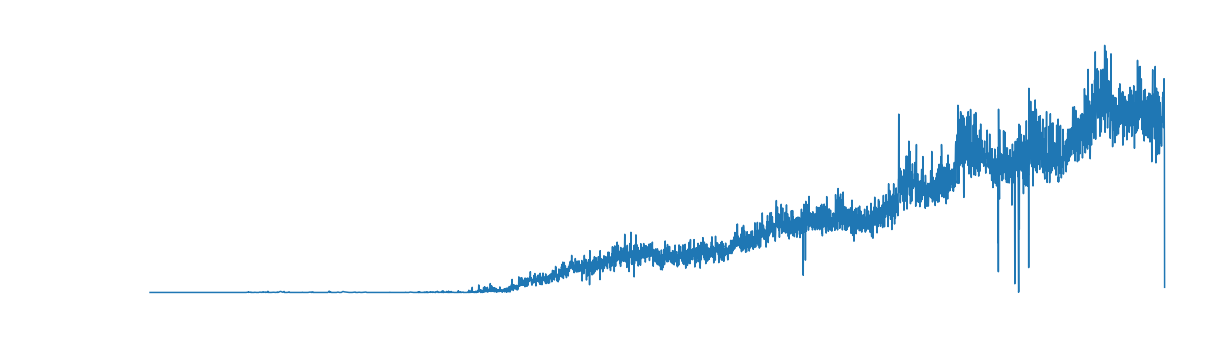

In [37]:
# Beer Reviews by Date
group_by_date = df_beer_reviews[ [ 'review_time' ] ].groupby( df_beer_reviews[ 'review_time' ].dt.date ).agg( [ 'count' ] )

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor" : "w"}
plt.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure( figsize = ( 20, 5 ) )
plt.plot( group_by_date )


plt.xlabel( 'Date' )
plt.ylabel( 'Number of reviews' )
plt.title( 'Number of Reviews per Day' )
plt.savefig('./charts/timeline.png', transparent=True, bbox_inches='tight',)
plt.show()

## Review Scores

In [38]:
col_numeric = [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv' ]

In [39]:
df_beer_reviews[col_numeric].describe()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
count,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00,1586251.00
mean,3.82,3.74,3.84,3.74,3.79,7.00
std,0.72,0.70,0.62,0.68,0.73,2.30
min,0.00,1.00,0.00,1.00,1.00,0.01
25%,3.50,3.50,3.50,3.50,3.50,5.20
50%,4.00,4.00,4.00,4.00,4.00,6.50
75%,4.50,4.00,4.00,4.00,4.50,8.50
max,5.00,5.00,5.00,5.00,5.00,57.70


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


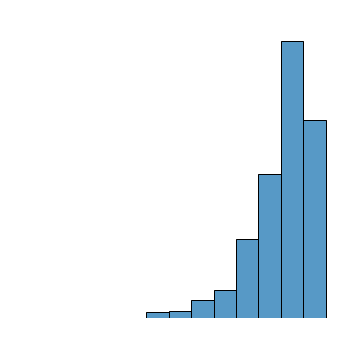

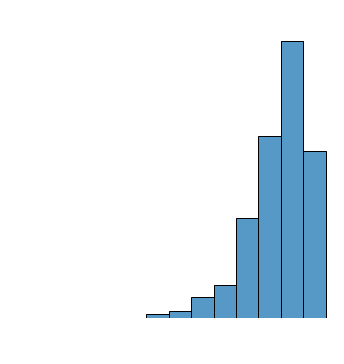

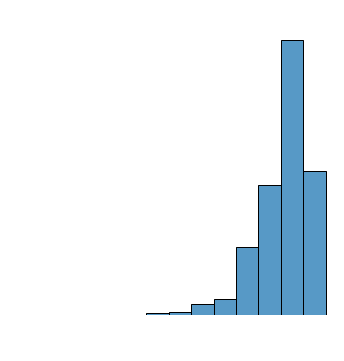

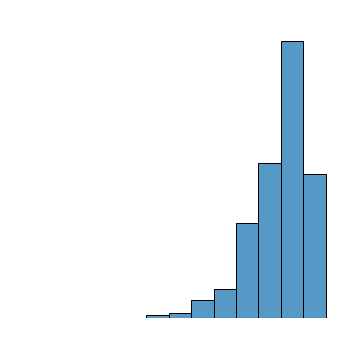

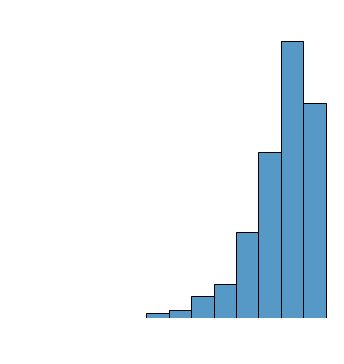

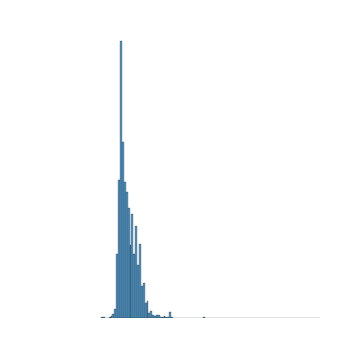

In [40]:
# sns.displot(data=df_beer_reviews, x='review_overall', bins=np.arange(0, df_beer_reviews['review_overall'].max() + 0.5, 0.5))
# plt.title("Displot of Overall Rating")
# sns.displot(data=df_beer_reviews, x='review_aroma', bins=np.arange(0, df_beer_reviews['review_aroma'].max() + 0.5, 0.5))
# plt.title("Displot of Aroma")
# sns.displot(data=df_beer_reviews, x='review_appearance', bins=np.arange(0, df_beer_reviews['review_appearance'].max() + 0.5, 0.5))
# plt.title("Displot of Appearance")
# sns.displot(data=df_beer_reviews, x='review_palate', bins=np.arange(0, df_beer_reviews['review_palate'].max() + 0.5, 0.5))
# plt.title("Displot of Palate")
# sns.displot(data=df_beer_reviews, x='review_taste', bins=np.arange(0, df_beer_reviews['review_taste'].max() + 0.5, 0.5))
# plt.title("Displot of Taste")
# sns.displot(data=df_beer_reviews, x='beer_abv', bins=np.arange(0, df_beer_reviews['beer_abv'].max() + 1 ,1))
# plt.title("Displot of ABV")

chart_subjects = ['review_overall','review_aroma','review_appearance','review_palate','review_taste','beer_abv']


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor" : "w"}
plt.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)


for subject in chart_subjects:
    plt.rcParams.update(params)
    plt.rc('font', **font)
    sns.displot(data=df_beer_reviews, x=subject, bins=np.arange(0, df_beer_reviews[subject].max() + 0.5, 0.5))
    plt.title(subject)
    savelocation ='./charts/'+subject+'.png'
    plt.savefig(savelocation, transparent=True, bbox_inches='tight')
    

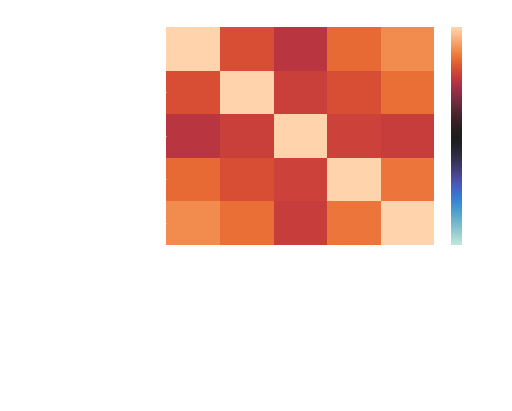

In [41]:
# Pearson correlation
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor" : "w"}
plt.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
sns.heatmap( df_beer_reviews[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste'] ].corr(), center = 0,  vmin = -1, vmax = 1 )
plt.title( 'Pearson Correlation' )

savelocation ='./charts/PearsonCorr.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)
    

In [42]:
score_corr = df_beer_reviews[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste'] ].corr()
score_corr['review_overall'].sort_values(ascending = False)

review_overall      1.00
review_taste        0.79
review_palate       0.70
review_aroma        0.62
review_appearance   0.50
Name: review_overall, dtype: float64

Text(0.5, 1.0, 'Spearman Correlation')

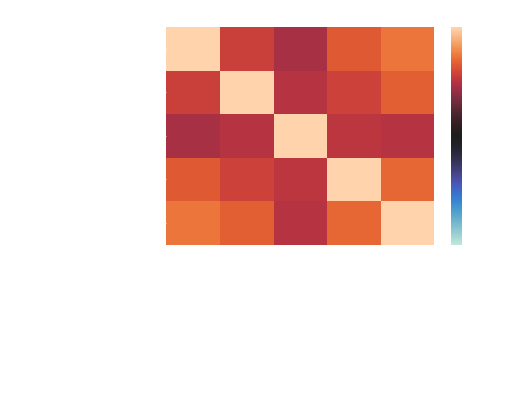

In [43]:
sns.heatmap( df_beer_reviews[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste'] ].corr( method = 'spearman' ), center = 0,  vmin = -1, vmax = 1 )
plt.title( 'Spearman Correlation' )

## Creating Aggregates

In [44]:
# This is a python implementarion of the Lower bound of Wilson score confidence interval for a Bernoulli parameter
# Implementation details: http://www.evanmiller.org/how-not-to-sort-by-average-rating.html?fbclid=IwAR2RNIB8geL9V0V9ereqidgRMasdytDOoqlGfCKWOcrRHKsUHFzMb7Xkemw

# pos: number of positive ratings
# n: total number of ratings
def ci_lower_bound( pos, n ):
    if n == 0:
        return 0
    z = 1.96 # For a IC of 0.95
    phat = 1.0 * pos / n
    return ( phat + ( z ** 2 ) / ( 2 * n ) - z * math.sqrt( ( phat * ( 1 - phat ) + ( z ** 2 ) / ( 4 * n ) ) / n ) ) / ( 1 + ( z ** 2 ) / n )

In [45]:
# Aggregation function for reviews
# Positive reviews are defined as a constant fraction of their real value
# Aggregation is performed using the Lower bound of Wilson score confidence interval for a Bernoulli parameter
def agg_reviews( reviews ):
    pos = 0
    for index, review in reviews[ reviews >= 3 ].iteritems():
        pos += review / 5
    #pos = ratings[ ratings >= 3 ].shape[ 0 ]
    return ci_lower_bound( pos, reviews.shape[ 0 ] ) * 5

## Individual Beers

In [46]:
# Create grouped beer dataframe using Aggregate Scores
col_descrip = ['beer_beerid','beer_name','brewery_name','beer_style','beer_abv','location', 'city', 'state/province', 'country']
df_groupby_beers = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : agg_reviews,
                                                            'review_taste' : agg_reviews,
                                                            'review_palate' : agg_reviews,
                                                            'review_aroma' : agg_reviews,
                                                            'review_appearance': agg_reviews,
                                                            'review_profilename' : 'count'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews' } )
df_groupby_beers = df_groupby_beers.set_index('beer_beerid')


In [47]:
# Create grouped beer dataframe using Mean  Scores
col_descrip = ['beer_beerid','beer_name','brewery_name','beer_style','beer_abv','location', 'city', 'state/province', 'country']
df_groupby_beers_mean = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : 'mean',
                                                            'review_taste' : 'mean',
                                                            'review_palate' : 'mean',
                                                            'review_aroma' : 'mean',
                                                            'review_appearance': 'mean',
                                                            'review_profilename' : 'count'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews' } )
df_groupby_beers_mean = df_groupby_beers_mean.set_index('beer_beerid')
df_groupby_beers_mean.sort_values( by = 'review_overall', ascending = False ).head()

,beer_name,brewery_name,beer_style,beer_abv,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews
beer_beerid,,,,,,,,,,,,,,
54011,AleSmith Speedway Stout - Oak Aged,AleSmith Brewing Company,American Double / Imperial Stout,12.00,"San Diego, CA",San Diego,CA,United States,5.00,4.50,5.00,4.50,5.00,1
61617,Galaxy Golden Ale,Lunar Brewing,American Blonde Ale,5.00,"Villa Park, IL",Villa Park,IL,United States,5.00,5.00,4.50,4.00,5.00,1
20177,Victory ESB,English Ales Brewery,Extra Special / Strong Bitter (ESB),5.77,"Marina, CA",Marina,CA,United States,5.00,4.50,4.00,4.00,4.50,1
25715,O'Ryan's Oatmeal Stout,Southend Brewery & Smokehouse,Oatmeal Stout,3.80,"Raleigh, NC",Raleigh,NC,United States,5.00,4.50,4.50,4.50,4.50,1
25718,Lucidity,Port Brewing Company / Pizza Port,Saison / Farmhouse Ale,7.02,"Carlsbad, CA",Carlsbad,CA,United States,5.00,4.50,4.50,5.00,4.50,1


In [48]:
df_groupby_beers.sort_values( by = 'number_of_reviews', ascending = False ).head()

,beer_name,brewery_name,beer_style,beer_abv,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews
beer_beerid,,,,,,,,,,,,,,
2093,90 Minute IPA,Dogfish Head Brewery,American Double / Imperial IPA,9.00,"Milton, DE",Milton,DE,United States,4.02,4.22,4.09,4.13,4.12,3289
412,Old Rasputin Russian Imperial Stout,North Coast Brewing Co.,Russian Imperial Stout,9.00,"Fort Bragg, CA",Fort Bragg,CA,United States,4.07,4.26,4.15,4.12,4.31,3110
1904,Sierra Nevada Celebration Ale,Sierra Nevada Brewing Co.,American IPA,6.80,"Chico, CA",Chico,CA,United States,4.06,4.08,3.98,3.99,4.15,2999
1093,Two Hearted Ale,"Bell's Brewery, Inc.",American IPA,7.00,"Kalamazoo, MI",Kalamazoo,MI,United States,4.24,4.24,4.05,4.19,4.07,2727
92,Arrogant Bastard Ale,Stone Brewing Co.,American Strong Ale,7.20,"Escondido, CA",Escondido,CA,United States,3.94,4.16,4.04,4.02,4.22,2702


In [49]:
df_groupby_beers_mean.describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews
count,64484.00,64484.00,64484.00,64484.00,64484.00,64484.00,64484.00
mean,6.23,3.65,3.60,3.57,3.55,3.68,24.41
std,1.90,0.62,0.63,0.58,0.59,0.51,112.05
min,0.01,1.00,1.00,1.00,1.00,1.00,1.00
25%,5.00,3.41,3.30,3.25,3.25,3.50,1.00
50%,5.80,3.75,3.69,3.66,3.57,3.75,2.00
75%,7.00,4.00,4.00,4.00,4.00,4.00,8.00
max,57.70,5.00,5.00,5.00,5.00,5.00,3289.00


In [50]:
print('Beers with  1 review:',df_groupby_beers[df_groupby_beers['number_of_reviews']==1]['number_of_reviews'].count())


Beers with  1 review: 23049


In [51]:
df_groupby_beers[['beer_name','beer_style','review_overall','number_of_reviews']].sort_values( by = 'number_of_reviews', ascending = False ).head()

,beer_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,
2093,90 Minute IPA,American Double / Imperial IPA,4.02,3289
412,Old Rasputin Russian Imperial Stout,Russian Imperial Stout,4.07,3110
1904,Sierra Nevada Celebration Ale,American IPA,4.06,2999
1093,Two Hearted Ale,American IPA,4.24,2727
92,Arrogant Bastard Ale,American Strong Ale,3.94,2702


In [52]:
df_groupby_beers[['beer_name','beer_style','review_overall','number_of_reviews']].sort_values( by = 'review_overall', ascending = False ).head()

,beer_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,
1545,Trappist Westvleteren 12,Quadrupel (Quad),4.53,1272
7971,Pliny The Elder,American Double / Imperial IPA,4.53,2527
16814,Heady Topper,American Double / Imperial IPA,4.49,469
21690,Pliny The Younger,American Double / Imperial IPA,4.47,610
47658,Founders CBS Imperial Stout,American Double / Imperial Stout,4.46,637


## Beer Style

In [53]:
col_descrip = ['beer_style']

df_groupby_style = df_beer_reviews.groupby(col_descrip).agg({'beer_abv': 'mean',
                                                            'review_overall' : agg_reviews,
                                                            'review_taste' : agg_reviews,
                                                            'review_palate' : agg_reviews,
                                                            'review_aroma' : agg_reviews,
                                                            'review_appearance': agg_reviews,
                                                            'review_profilename' : 'count',
                                                            'beer_name': 'nunique'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews','beer_name' : 'number_of_beers' } )

In [54]:
df_groupby_style.describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00
mean,6.45,3.47,3.41,3.38,3.34,3.56,15252.41,566.16
std,1.94,0.51,0.63,0.57,0.69,0.52,17827.00,558.60
min,0.57,1.45,0.96,1.09,0.77,1.21,241.00,19.00
25%,5.18,3.40,3.26,3.27,3.14,3.46,3952.25,182.75
50%,5.82,3.62,3.55,3.51,3.51,3.71,9975.50,411.00
75%,7.60,3.76,3.82,3.76,3.79,3.88,19640.75,743.00
max,11.39,3.98,4.13,4.05,4.10,4.17,117566.00,3167.00


In [55]:
df_groupby_style.sort_values( by = 'number_of_reviews', ascending = False ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
12,American IPA,6.64,3.87,3.82,3.79,3.80,3.92,117566,3167
9,American Double / Imperial IPA,9.37,3.90,4.01,3.96,4.04,4.04,85958,1435
14,American Pale Ale (APA),5.47,3.71,3.55,3.54,3.49,3.70,63460,2887
89,Russian Imperial Stout,9.99,3.92,4.07,4.00,4.02,4.17,54120,759
11,American Double / Imperial Stout,10.61,3.92,4.10,4.02,4.10,4.12,50696,874


In [56]:
df_groupby_style.sort_values( by = 'number_of_reviews', ascending = True ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
64,Happoshu,5.27,1.89,1.48,1.65,1.24,1.96,241,71
72,Kvass,2.01,2.64,2.63,2.43,2.65,2.98,297,43
88,Roggenbier,5.62,3.68,3.66,3.54,3.60,3.55,466,54
56,Faro,4.68,3.16,3.21,3.31,3.37,3.49,608,19
62,Gose,4.69,3.71,3.67,3.69,3.53,3.73,686,27


In [57]:
df_groupby_style.sort_values( by = 'review_overall', ascending = False ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
20,American Wild Ale,7.71,3.98,4.05,3.95,4.05,3.94,17794,715
86,Quadrupel (Quad),10.46,3.97,4.13,4.05,4.07,4.06,18084,192
63,Gueuze,5.60,3.95,4.00,3.93,4.01,3.95,6007,93
89,Russian Imperial Stout,9.99,3.92,4.07,4.00,4.02,4.17,54120,759
11,American Double / Imperial Stout,10.61,3.92,4.10,4.02,4.10,4.12,50696,874


In [58]:
df_groupby_style.sort_values( by = 'review_overall', ascending = True ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
77,Low Alcohol Beer,0.57,1.45,1.18,1.34,1.17,2.00,1201,161
13,American Malt Liquor,7.37,1.68,1.42,1.59,1.13,1.91,3923,144
76,Light Lager,4.03,1.71,0.96,1.09,0.77,1.21,14308,589
64,Happoshu,5.27,1.89,1.48,1.65,1.24,1.96,241,71
54,Euro Strong Lager,8.03,1.94,1.86,2.17,1.96,2.70,2724,275


In [59]:
df_groupby_style.sort_values( by = 'beer_abv', ascending = False ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
41,Eisbock,11.39,3.82,4.10,4.00,4.05,3.85,2663,63
42,English Barleywine,10.92,3.68,3.86,3.81,3.87,3.83,13730,375
4,American Barleywine,10.70,3.77,3.94,3.92,3.96,3.99,26721,784
101,Wheatwine,10.66,3.62,3.82,3.81,3.86,3.80,3714,114
28,Bière de Champagne / Bière Brut,10.62,3.21,3.27,3.46,3.41,3.86,1046,20


In [60]:
df_groupby_style.sort_values( by = 'beer_abv', ascending = True ).head()

,beer_style,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers
77,Low Alcohol Beer,0.57,1.45,1.18,1.34,1.17,2.00,1201,161
72,Kvass,2.01,2.64,2.63,2.43,2.65,2.98,297,43
76,Light Lager,4.03,1.71,0.96,1.09,0.77,1.21,14308,589
45,English Dark Mild Ale,4.06,3.58,3.34,3.24,3.27,3.58,2313,388
27,Berliner Weissbier,4.22,3.66,3.59,3.58,3.43,3.49,3474,95


In [61]:
df_groupby_style[['beer_style','review_overall']].sort_values( by = 'review_overall', ascending = False ).head()

,beer_style,review_overall
20,American Wild Ale,3.98
86,Quadrupel (Quad),3.97
63,Gueuze,3.95
89,Russian Imperial Stout,3.92
11,American Double / Imperial Stout,3.92


## Breweries

In [62]:
col_descrip = ['brewery_name','location', 'city', 'state/province', 'country']

df_groupby_brewery = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : agg_reviews,
                                                            'review_taste' : agg_reviews,
                                                            'review_palate' : agg_reviews,
                                                            'review_aroma' : agg_reviews,
                                                            'review_appearance': agg_reviews,
                                                            'beer_style': 'nunique',
                                                            'review_profilename' : 'count',
                                                            'beer_name': 'nunique'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews', 'beer_name' : 'number_of_beers', 'beer_style':'number_of_styles' } )


In [63]:
df_groupby_brewery.describe()

,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_styles,number_of_reviews,number_of_beers
count,5804.00,5804.00,5804.00,5804.00,5804.00,5804.00,5804.00,5804.00
mean,1.92,1.84,1.83,1.80,2.01,7.39,271.24,11.10
std,1.09,1.10,1.08,1.09,1.09,8.66,1490.99,18.86
min,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
25%,0.99,0.87,0.91,0.87,1.10,2.00,3.00,2.00
50%,1.89,1.77,1.79,1.76,2.03,4.00,14.00,5.00
75%,2.86,2.78,2.76,2.73,2.95,9.00,70.00,12.00
max,4.48,4.53,4.45,4.48,4.33,83.00,39438.00,394.00


In [64]:
df_groupby_brewery.sort_values( by = 'number_of_reviews', ascending = False ).head()

,brewery_name,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_styles,number_of_reviews,number_of_beers
710,Boston Beer Company (Samuel Adams),"Jamaica Plain, MA",Jamaica Plain,MA,United States,3.48,3.43,3.48,3.40,3.73,57,39438,133
1976,Dogfish Head Brewery,"Milton, DE",Milton,DE,United States,3.67,3.85,3.79,3.82,3.89,53,33829,116
5005,Stone Brewing Co.,"Escondido, CA",Escondido,CA,United States,3.95,4.07,4.02,4.04,4.12,30,33053,134
4791,Sierra Nevada Brewing Co.,"Chico, CA",Chico,CA,United States,3.98,3.95,3.90,3.82,4.06,51,28746,140
421,"Bell's Brewery, Inc.","Kalamazoo, MI",Kalamazoo,MI,United States,3.86,3.91,3.88,3.84,3.92,40,25189,121


In [65]:
df_groupby_brewery.sort_values( by = 'number_of_beers', ascending = False ).head()

,brewery_name,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_styles,number_of_reviews,number_of_beers
2990,John Harvard's Brewery & Ale House,"Framingham, MA",Framingham,MA,United States,3.63,3.56,3.50,3.39,3.62,83,1105,394
2435,Goose Island Beer Co.,"Chicago, IL",Chicago,IL,United States,3.89,3.92,3.85,3.86,3.86,67,14532,368
3672,Minneapolis Town Hall Brewery,"Minneapolis, MN",Minneapolis,MN,United States,4.15,4.11,4.04,4.07,4.05,65,2914,312
4265,Port Brewing Company / Pizza Port,"Carlsbad, CA",Carlsbad,CA,United States,3.89,4.00,3.87,3.98,3.93,59,7297,283
1712,Cigar City Brewing,"Tampa, FL",Tampa,FL,United States,3.89,3.96,3.92,3.95,4.05,45,6708,201


In [66]:
df_groupby_brewery.sort_values( by = 'review_overall', ascending = False ).head()

,brewery_name,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_styles,number_of_reviews,number_of_beers
1351,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,"Westvleteren, Belgium",Westvleteren,Belgium,Belgium,4.48,4.53,4.45,4.40,4.33,4,2378,5
5142,The Alchemist,"Waterbury, VT",Waterbury,VT,United States,4.45,4.44,4.23,4.48,3.98,2,527,3
4584,Russian River Brewing Company,"Santa Rosa, CA",Santa Rosa,CA,United States,4.33,4.37,4.24,4.31,4.19,26,11311,65
369,Bayerische Staatsbrauerei Weihenstephan,"Freising, Germany",Freising,Germany,Germany,4.22,4.12,4.03,3.98,4.08,10,6263,15
2728,Hill Farmstead Brewery,"Greensboro Bend, VT",Greensboro Bend,VT,United States,4.20,4.19,4.07,4.20,4.10,15,1531,53


In [67]:
df_groupby_brewery[['brewery_name','location','review_overall']].sort_values( by = 'review_overall', ascending = False ).head()

,brewery_name,location,review_overall
1351,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,"Westvleteren, Belgium",4.48
5142,The Alchemist,"Waterbury, VT",4.45
4584,Russian River Brewing Company,"Santa Rosa, CA",4.33
369,Bayerische Staatsbrauerei Weihenstephan,"Freising, Germany",4.22
2728,Hill Farmstead Brewery,"Greensboro Bend, VT",4.20


# Location

In [68]:
col_descrip = ['city', 'state/province', 'country']

df_groupby_city = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : agg_reviews,
                                                            'review_taste' : agg_reviews,
                                                            'review_palate' : agg_reviews,
                                                            'review_aroma' : agg_reviews,
                                                            'review_appearance': agg_reviews,
                                                            'review_profilename' : 'count',
                                                            'brewery_name': 'nunique',
                                                            'beer_name': 'nunique'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews', 'brewery_name':'number_of_breweries', 'beer_name' : 'number_of_beers' } )
df_groupby_city.sort_values( by = 'number_of_reviews', ascending = False ).head()

,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_breweries,number_of_beers
1616,Jamaica Plain,MA,United States,3.48,3.43,3.48,3.40,3.73,39438,1,133
2232,Milton,DE,United States,3.67,3.85,3.79,3.82,3.89,33829,1,116
1044,Escondido,CA,United States,3.95,4.07,4.02,4.04,4.12,33057,2,138
686,Chico,CA,United States,3.98,3.95,3.90,3.82,4.06,28746,1,140
1656,Kalamazoo,MI,United States,3.85,3.90,3.88,3.84,3.92,25349,5,179


In [69]:
col_descrip = ['country']

df_groupby_country = df_beer_reviews.groupby(col_descrip).agg({'review_overall' : agg_reviews,
                                                            'review_taste' : agg_reviews,
                                                            'review_palate' : agg_reviews,
                                                            'review_aroma' : agg_reviews,
                                                            'review_appearance': agg_reviews,
                                                            'review_profilename' : 'count',
                                                            'beer_name': 'nunique',
                                                            'brewery_name': 'nunique'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews', 'brewery_name':'number_of_breweries', 'beer_name' : 'number_of_beers', 'brewery_name': 'number_of_breweries' } )
df_groupby_country.sort_values( by = 'number_of_reviews', ascending = False ).head()

,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_beers,number_of_breweries
171,United States,3.69,3.65,3.62,3.61,3.77,1148130,35464,2288
15,Belgium,3.86,3.91,3.85,3.88,3.99,118177,2039,185
73,Germany,3.78,3.67,3.63,3.54,3.73,66010,2548,614
30,Canada,3.48,3.40,3.35,3.34,3.53,52843,3668,297
61,England,3.66,3.62,3.58,3.53,3.80,51932,2602,416


In [70]:
df_groupby_country[['country','review_overall','number_of_reviews','number_of_beers','number_of_breweries']].sort_values( by = 'number_of_reviews', ascending = False ).head()

,country,review_overall,number_of_reviews,number_of_beers,number_of_breweries
171,United States,3.69,1148130,35464,2288
15,Belgium,3.86,118177,2039,185
73,Germany,3.78,66010,2548,614
30,Canada,3.48,52843,3668,297
61,England,3.66,51932,2602,416


# Modeling

# Clustering


In [71]:
df_groupby_beers_mean['number_of_reviews_log'] = np.log(df_groupby_beers['number_of_reviews'])
df_groupby_beers_mean['number_of_reviews_sr'] = np.sqrt(df_groupby_beers['number_of_reviews'])
df_groupby_beers_mean['number_of_reviews_cr'] = np.cbrt(df_groupby_beers['number_of_reviews'])


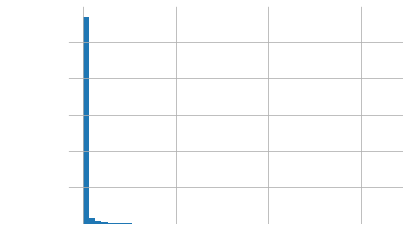

In [72]:
df_groupby_beers_mean['number_of_reviews'].hist(bins=50, density=True)
savelocation ='./charts/NumReview.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)

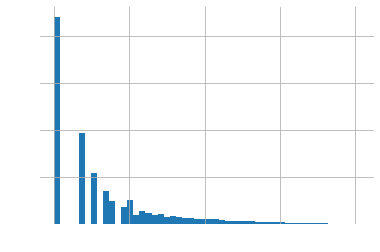

In [73]:
df_groupby_beers_mean['number_of_reviews_log'].hist(bins=50, density=True)
savelocation ='./charts/NumReviewLog.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)

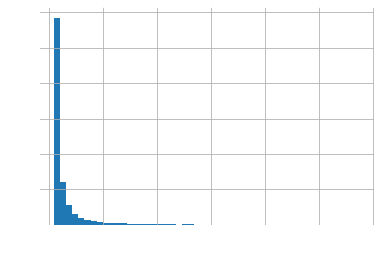

In [74]:
df_groupby_beers_mean['number_of_reviews_sr'].hist(bins=50, density=True)
savelocation ='./charts/Numreviewsqr.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)

In [75]:
#  Group by Beer
# Use Score and Number of Reviews (USe overall score as subscores corralate)
# Use mean as the aggregrate since score and number of reviews will be used

df_beer_reviews_cluster  = df_groupby_beers_mean[[ 'review_overall','number_of_reviews_sr']]
df_beer_reviews_cluster = df_beer_reviews_cluster.set_index(df_groupby_beers.index)



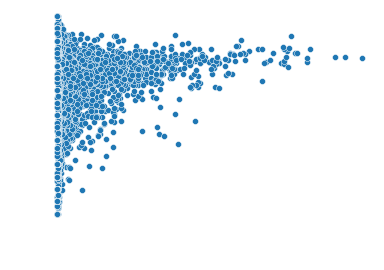

In [76]:


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor" : "w"}
plt.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
sns.scatterplot(x=df_groupby_beers_mean['number_of_reviews'], y=df_groupby_beers_mean['review_overall'])

savelocation ='./charts/OverallRating_Number_Reviews.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)

In [77]:
# Verify Data
df_beer_reviews_cluster



,review_overall,number_of_reviews_sr
beer_beerid,,
3,4.17,1.73
4,3.70,3.16
5,3.55,20.59
6,3.71,29.61
7,3.27,25.67
...,...,...
77313,3.00,1.00
77314,3.50,1.00
77315,3.50,1.00


In [78]:
# Scale Data
from sklearn.preprocessing import StandardScaler
X = df_beer_reviews_cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=df_beer_reviews_cluster.columns, index=df_beer_reviews_cluster.index)

In [79]:
X_scaled

,review_overall,number_of_reviews_sr
beer_beerid,,
3,0.82,-0.28
4,0.07,0.07
5,-0.17,4.41
6,0.09,6.66
7,-0.62,5.67
...,...,...
77313,-1.05,-0.47
77314,-0.25,-0.47
77315,-0.25,-0.47


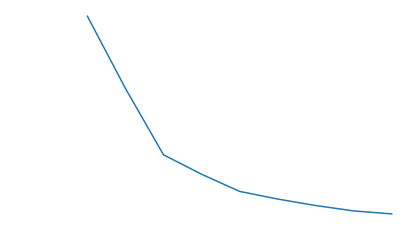

In [80]:
# Elbow Method for Finding Optimal Number of Clusters
n_clusters = list(range(1, 10))
within_cluster_var = []
for i in n_clusters:
    clu = cluster.KMeans(n_clusters=i)
    clu = clu.fit(X_scaled)
    within_cluster_var.append(clu.inertia_)
plt.plot(within_cluster_var)
savelocation ='./charts/Elbow.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight',)
plt.show()


In [81]:
# Perform KMeans Clustering
kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(X_scaled)

# Get the cluster labels
labels = kmeans.labels_

In [82]:
# Add Cluster Labels to Data
X_scaled_labeled = X_scaled.copy()
X_scaled_labeled['group'] = labels
X_scaled_labeled

,review_overall,number_of_reviews_sr,group
beer_beerid,,,
3,0.82,-0.28,0
4,0.07,0.07,1
5,-0.17,4.41,3
6,0.09,6.66,3
7,-0.62,5.67,3
...,...,...,...
77313,-1.05,-0.47,1
77314,-0.25,-0.47,1
77315,-0.25,-0.47,1


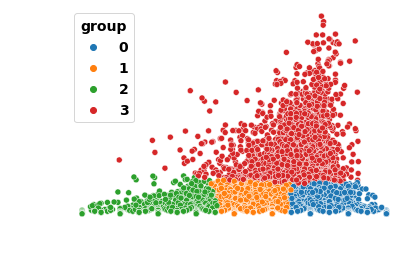

In [83]:
# Plot Clusters
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor" : "w"}
plt.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

sns.scatterplot(x=X_scaled_labeled['review_overall'], y=X_scaled_labeled['number_of_reviews_sr'], hue=X_scaled_labeled['group'], palette="tab10")

savelocation ='./charts/clusters.png'
plt.savefig(savelocation, transparent=True, bbox_inches='tight')

plt.show()

In [84]:
df_groupby_beers_mean

,beer_name,brewery_name,beer_style,beer_abv,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr
beer_beerid,,,,,,,,,,,,,,,,,
3,Cactus Queen IPA,Yellow Rose Brewing Company,American IPA,6.64,"San Antonio, TX",San Antonio,TX,United States,4.17,4.17,4.17,4.00,3.83,3,1.10,1.73,1.44
4,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout,6.28,"San Antonio, TX",San Antonio,TX,United States,3.70,3.45,3.70,3.80,3.95,10,2.30,3.16,2.15
5,Amber,Abita Brewing Co.,Vienna Lager,4.50,"Covington, LA",Covington,LA,United States,3.55,3.34,3.32,3.21,3.49,424,6.05,20.59,7.51
6,Turbodog,Abita Brewing Co.,English Brown Ale,5.60,"Covington, LA",Covington,LA,United States,3.71,3.65,3.51,3.52,3.84,877,6.78,29.61,9.57
7,Purple Haze,Abita Brewing Co.,Fruit / Vegetable Beer,4.20,"Covington, LA",Covington,LA,United States,3.27,3.10,3.11,3.18,3.25,659,6.49,25.67,8.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77313,Aass Gourmet Pale Ale,Aass Brewery,American Blonde Ale,4.70,"Drammen, Norway",Drammen,Norway,Norway,3.00,3.00,3.00,3.00,4.00,1,0.00,1.00,1.00
77314,Betty Brown Norwegian Brwon Ale,Lervig Aktiebryggeri AS,American Brown Ale,4.70,"Stavanger, Norway",Stavanger,Norway,Norway,3.50,4.00,3.00,3.50,4.00,1,0.00,1.00,1.00
77315,Icelandic White Beer,Einstök Ölgerð,Witbier,5.20,"Akureyri, Iceland",Akureyri,Iceland,Iceland,3.50,3.50,3.00,4.50,3.00,1,0.00,1.00,1.00


In [85]:
# Add clusters to dframs
df_groupby_beers_clustered = df_groupby_beers.merge(X_scaled_labeled['group'], left_index=True, right_index=True)
df_groupby_beers_mean_clustered = df_groupby_beers_mean.merge(X_scaled_labeled['group'], left_index=True, right_index=True)


In [86]:
display_col_long = ['beer_name','brewery_name','beer_style','review_overall','number_of_reviews']


In [87]:
df_groupby_beers_mean_clustered[df_groupby_beers_mean_clustered['group'] == 1]

,beer_name,brewery_name,beer_style,beer_abv,location,city,state/province,country,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr,group
beer_beerid,,,,,,,,,,,,,,,,,,
4,Wildcatter's Crude Stout,Yellow Rose Brewing Company,American Stout,6.28,"San Antonio, TX",San Antonio,TX,United States,3.70,3.45,3.70,3.80,3.95,10,2.30,3.16,2.15,1
8,Wheat,Abita Brewing Co.,American Adjunct Lager,4.20,"Covington, LA",Covington,LA,United States,3.65,3.24,3.30,3.08,3.29,68,4.22,8.25,4.08,1
11,Bert Grant's Scottish Ale,Yakima Brewing Co. / Bert Grant's Ales,Scottish Ale,4.70,"Yakima, WA",Yakima,WA,United States,3.39,3.27,3.24,3.39,3.50,85,4.44,9.22,4.40,1
12,Bert Grant's Imperial Stout,Yakima Brewing Co. / Bert Grant's Ales,Russian Imperial Stout,6.00,"Yakima, WA",Yakima,WA,United States,3.71,3.69,3.53,3.77,4.08,86,4.45,9.27,4.41,1
13,Bert Grant's IPA,Yakima Brewing Co. / Bert Grant's Ales,English India Pale Ale (IPA),4.20,"Yakima, WA",Yakima,WA,United States,3.25,3.03,3.10,3.06,3.10,84,4.43,9.17,4.38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77313,Aass Gourmet Pale Ale,Aass Brewery,American Blonde Ale,4.70,"Drammen, Norway",Drammen,Norway,Norway,3.00,3.00,3.00,3.00,4.00,1,0.00,1.00,1.00,1
77314,Betty Brown Norwegian Brwon Ale,Lervig Aktiebryggeri AS,American Brown Ale,4.70,"Stavanger, Norway",Stavanger,Norway,Norway,3.50,4.00,3.00,3.50,4.00,1,0.00,1.00,1.00,1
77315,Icelandic White Beer,Einstök Ölgerð,Witbier,5.20,"Akureyri, Iceland",Akureyri,Iceland,Iceland,3.50,3.50,3.00,4.50,3.00,1,0.00,1.00,1.00,1


In [88]:
df_groupby_beers_clusters = []
for i in range(4):
    df_groupby_beers_clusters.append(df_groupby_beers_mean_clustered[df_groupby_beers_mean_clustered['group'] == i])

In [89]:
df_groupby_beers_clusters[0][display_col_long].sort_values(by='number_of_reviews', ascending = False).head(10)

,beer_name,brewery_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,,
61100,King Henry,Goose Island Beer Co.,English Barleywine,4.62,98
47580,Ola Dubh Special Reserve 40,Harviestoun Brewery Ltd.,Old Ale,4.16,96
68662,"December 6th, 1855 EIP",Pretty Things Beer & Ale Project,English Porter,4.12,95
2669,Portsmouth Black Cat Stout,Portsmouth Brewery,Irish Dry Stout,4.15,95
47747,Red Eye Coffee Porter,Two Brothers Brewing Company,American Porter,4.15,95
32385,XS Imperial Porter,Rogue Ales,American Porter,4.03,94
578,Thomas Hardy's Ale (1968-1999),O'Hanlon's Brewing Co. Ltd.,Old Ale,4.30,94
8294,Stone Old Guardian Barley Wine Style Ale 2003,Stone Brewing Co.,American Barleywine,4.19,94
22192,Brownstone,Sixpoint Brewery,American Brown Ale,4.11,94


In [90]:
df_groupby_beers_clusters[0].describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr,group
count,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00,32372.00
mean,6.46,4.10,3.99,3.91,3.86,3.91,7.28,1.11,2.13,1.58,0.00
std,1.93,0.27,0.35,0.36,0.40,0.37,13.63,1.17,1.66,0.75,0.00
min,0.01,3.73,1.00,1.50,1.00,1.50,1.00,0.00,1.00,1.00,0.00
25%,5.12,4.00,3.75,3.71,3.50,3.75,1.00,0.00,1.00,1.00,0.00
50%,6.00,4.00,4.00,4.00,3.94,4.00,2.00,0.69,1.41,1.26,0.00
75%,7.30,4.25,4.17,4.00,4.00,4.03,6.00,1.79,2.45,1.82,0.00
max,57.70,5.00,5.00,5.00,5.00,5.00,98.00,4.58,9.90,4.61,0.00


In [91]:
df_groupby_beers_clusters[0]['beer_style'].value_counts()

American IPA                       2162
American Pale Ale (APA)            1771
American Porter                    1264
American Amber / Red Ale           1083
American Double / Imperial IPA      937
                                   ... 
Happoshu                             13
Japanese Rice Lager                  13
Kvass                                13
Faro                                  9
Bière de Champagne / Bière Brut       9
Name: beer_style, Length: 104, dtype: int64

In [92]:
df_groupby_beers_clusters[1][display_col_long].sort_values(by='number_of_reviews', ascending = False).head(10)

,beer_name,brewery_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,,
52787,Odd Notion (Winter 09),Magic Hat Brewing Company,American Wild Ale,2.86,111
2124,Yanjing Beer,Beijing Yanjing Beer Group Corporation,American Adjunct Lager,2.86,109
47562,It's Alright!,Mikkeller ApS,Belgian Pale Ale,2.79,107
23381,Brahma,Companhia Cervejaria Brahma,American Adjunct Lager,2.78,106
67274,Shiner Ruby Redbird,Spoetzl Brewery,Fruit / Vegetable Beer,3.00,105
21505,Lammin Kataja Olut,Lammin Sahti Oy,Sahti,3.17,104
3050,Kalik,Commonwealth Brewery Ltd.,American Adjunct Lager,2.94,104
7018,Cusquena Premium Peruvian Beer,Compania Cervecera Del Sur Del Peru S.A. (Cerv...,American Adjunct Lager,3.08,103
2472,Kokanee,Labatt Brewing Company Ltd.,American Adjunct Lager,3.05,102


In [93]:
df_groupby_beers_clusters[1].describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr,group
count,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00,23328.00
mean,5.97,3.35,3.34,3.34,3.35,3.53,8.18,1.19,2.25,1.63,1.00
std,1.73,0.25,0.39,0.40,0.43,0.43,14.74,1.23,1.76,0.79,0.00
min,0.10,2.70,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00
25%,5.00,3.11,3.00,3.00,3.00,3.27,1.00,0.00,1.00,1.00,1.00
50%,5.50,3.50,3.44,3.42,3.43,3.50,3.00,1.10,1.73,1.44,1.00
75%,6.59,3.50,3.50,3.55,3.56,3.83,7.00,1.95,2.65,1.91,1.00
max,41.00,3.75,5.00,5.00,5.00,5.00,111.00,4.71,10.54,4.81,1.00


In [94]:
df_groupby_beers_clusters[1]['beer_style'].value_counts()

American Pale Ale (APA)            1154
American Amber / Red Ale           1085
American IPA                        990
Fruit / Vegetable Beer              792
Euro Pale Lager                     737
                                   ... 
Roggenbier                           12
Sahti                                10
Faro                                  9
Bière de Champagne / Bière Brut       9
Gose                                  5
Name: beer_style, Length: 104, dtype: int64

In [95]:
df_groupby_beers_clusters[2][display_col_long].sort_values(by='number_of_reviews', ascending = False).head(10)

,beer_name,brewery_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,,
2947,Keystone Ice,Coors Brewing Company,American Adjunct Lager,2.33,139
37389,Budweiser Chelada,Anheuser-Busch,Fruit / Vegetable Beer,1.93,138
38763,Original C Cave Creek Chili Beer - Cerveza Con...,Chili Beer Co.,Chile Beer,1.68,132
1541,Victoria Bitter (VB),"Carlton & United Breweries, Ltd.",American Adjunct Lager,2.48,128
20638,Bud Extra,Anheuser-Busch,Herbed / Spiced Beer,1.95,128
41127,Mamma Mia! Pizza Beer,Pizza Beer Company,Herbed / Spiced Beer,2.38,117
5294,Famosa (Gallo),"Cervecería Centro Americana, S.A.",American Adjunct Lager,2.36,115
37424,Bud Light Chelada,Anheuser-Busch,Fruit / Vegetable Beer,1.71,114
27004,Michelob Celebrate Vanilla Oak,Anheuser-Busch,American Pale Lager,2.50,109


In [96]:
df_groupby_beers_clusters[2].describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr,group
count,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00,5586.00
mean,5.52,2.24,2.30,2.49,2.52,2.95,4.03,0.70,1.63,1.34,2.00
std,1.74,0.45,0.55,0.60,0.63,0.67,9.42,0.93,1.17,0.54,0.00
min,0.01,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,2.00
25%,4.70,2.00,2.00,2.00,2.00,2.50,1.00,0.00,1.00,1.00,2.00
50%,5.19,2.50,2.50,2.50,2.50,3.00,1.00,0.00,1.00,1.00,2.00
75%,6.10,2.50,2.61,3.00,3.00,3.50,3.00,1.10,1.73,1.44,2.00
max,19.50,2.78,5.00,5.00,5.00,5.00,139.00,4.93,11.79,5.18,2.00


In [97]:
df_groupby_beers_clusters[2]['beer_style'].value_counts()

Euro Pale Lager            502
American Adjunct Lager     468
Fruit / Vegetable Beer     317
Light Lager                251
American Pale Ale (APA)    200
                          ... 
Gueuze                       4
Flanders Red Ale             4
Braggot                      3
Roggenbier                   2
Sahti                        1
Name: beer_style, Length: 100, dtype: int64

In [98]:
df_groupby_beers_clusters[3][display_col_long].sort_values(by='number_of_reviews', ascending = False).head(10)

,beer_name,brewery_name,beer_style,review_overall,number_of_reviews
beer_beerid,,,,,
2093,90 Minute IPA,Dogfish Head Brewery,American Double / Imperial IPA,4.15,3289
412,Old Rasputin Russian Imperial Stout,North Coast Brewing Co.,Russian Imperial Stout,4.17,3110
1904,Sierra Nevada Celebration Ale,Sierra Nevada Brewing Co.,American IPA,4.17,2999
1093,Two Hearted Ale,"Bell's Brewery, Inc.",American IPA,4.33,2727
4083,Stone Ruination IPA,Stone Brewing Co.,American Double / Imperial IPA,4.16,2702
92,Arrogant Bastard Ale,Stone Brewing Co.,American Strong Ale,4.08,2702
276,Sierra Nevada Pale Ale,Sierra Nevada Brewing Co.,American Pale Ale (APA),4.25,2587
88,Stone IPA (India Pale Ale),Stone Brewing Co.,American IPA,4.26,2574
7971,Pliny The Elder,Russian River Brewing Company,American Double / Imperial IPA,4.59,2527


In [99]:
df_groupby_beers_clusters[3].describe()

,beer_abv,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews,number_of_reviews_log,number_of_reviews_sr,number_of_reviews_cr,group
count,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00
mean,7.06,3.81,3.78,3.74,3.73,3.84,351.88,5.53,17.17,6.54,3.00
std,2.29,0.33,0.40,0.35,0.41,0.33,369.76,0.75,7.55,1.81,0.00
min,0.50,1.49,1.66,1.72,1.64,1.83,91.00,4.51,9.54,4.50,3.00
25%,5.30,3.66,3.59,3.58,3.54,3.70,138.00,4.93,11.75,5.17,3.00
50%,6.50,3.85,3.84,3.79,3.80,3.89,218.00,5.38,14.76,6.02,3.00
75%,8.50,4.02,4.05,3.97,4.00,4.05,402.75,6.00,20.07,7.38,3.00
max,27.00,4.63,4.77,4.67,4.72,4.64,3289.00,8.10,57.35,14.87,3.00


In [100]:
df_groupby_beers_clusters[3]['beer_style'].value_counts()

American IPA                        209
American Double / Imperial IPA      158
American Pale Ale (APA)             133
American Porter                     104
American Double / Imperial Stout     93
                                   ... 
Bière de Champagne / Bière Brut       2
Low Alcohol Beer                      1
Faro                                  1
English Pale Mild Ale                 1
Gose                                  1
Name: beer_style, Length: 101, dtype: int64

# Reccomendations

## Content Based

If you had to pick five beers to recommend, which would you pick?

In [101]:
df_groupby_beers_clustered.set_index(['beer_name','brewery_name','number_of_reviews']).groupby('beer_style')['review_overall'].nlargest(1).reset_index(name='review_overall').sort_values('review_overall',ascending = False).head(5)


,beer_style,beer_name,brewery_name,number_of_reviews,review_overall
86,Quadrupel (Quad),Trappist Westvleteren 12,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,1272,4.53
9,American Double / Imperial IPA,Pliny The Elder,Russian River Brewing Company,2527,4.53
11,American Double / Imperial Stout,Founders CBS Imperial Stout,Founders Brewing Company,637,4.46
65,Hefeweizen,Weihenstephaner Hefeweissbier,Bayerische Staatsbrauerei Weihenstephan,1980,4.44
39,Dubbel,Trappist Westvleteren 8,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,707,4.39


If I usually enjoy IPAs, which beer should I try?

In [102]:
ipas = df_groupby_beers_clustered[df_groupby_beers_clustered['beer_style'].str.contains('IPA')]

ipas = ipas.set_index(['beer_name','brewery_name','number_of_reviews']).groupby('group')['review_overall'].nlargest(3).reset_index(name='review_overall')

ipas = ipas[ipas['review_overall']>4]
ipas

,group,beer_name,brewery_name,number_of_reviews,review_overall
0,0,Double Sunshine IPA,Lawson's Finest Liquids,85,4.20
1,0,Galaxy Imperial Single Hop IPA,Hill Farmstead Brewery,76,4.17
2,0,India Pale Ale,Selin's Grove Brewing Company,84,4.05
9,3,Pliny The Elder,Russian River Brewing Company,2527,4.53
10,3,Heady Topper,The Alchemist,469,4.49
11,3,Pliny The Younger,Russian River Brewing Company,610,4.47


## Collabrative

If I enjoy Shiner Bock, what would other people who like it recommend?

In [103]:
beer_id = 1352
style = df_groupby_beers.loc[[beer_id]]['beer_style'].values[0]
users_who_like = df_beer_reviews[(df_beer_reviews['beer_beerid'] == beer_id) & (df_beer_reviews['review_overall'] >= 4)]
users_who_like = users_who_like['review_profilename'].drop_duplicates()
df = df_beer_reviews[df_beer_reviews['review_profilename'].isin(users_who_like.to_list())]

col_descrip = ['beer_beerid','beer_name','brewery_name','beer_style','beer_abv']
df_beer_rec = df.groupby(col_descrip).agg({'review_overall' : agg_reviews,
                                            'review_profilename' : 'count'}).reset_index().rename( columns = { 'review_profilename' : 'number_of_reviews' } )
df_beer_rec = df_beer_rec.set_index('beer_beerid')
df_beer_rec.sort_values( by = 'review_overall', ascending = False ).head()

,beer_name,brewery_name,beer_style,beer_abv,review_overall,number_of_reviews
beer_beerid,,,,,,
731,Weihenstephaner Hefeweissbier,Bayerische Staatsbrauerei Weihenstephan,Hefeweizen,5.40,4.18,88
7971,Pliny The Elder,Russian River Brewing Company,American Double / Imperial IPA,8.00,4.09,71
34,La Fin Du Monde,Unibroue,Tripel,9.00,4.03,111
34420,The Abyss,Deschutes Brewery,American Double / Imperial Stout,11.00,4.01,41
1708,St. Bernardus Abt 12,Brouwerij St. Bernardus NV,Quadrupel (Quad),10.00,4.00,94


In [104]:
df_beer_rec[(df_beer_rec['beer_style'] == style) & (df_beer_rec.index != beer_id)].sort_values( by = 'review_overall', ascending = False ).head()

,beer_name,brewery_name,beer_style,beer_abv,review_overall,number_of_reviews
beer_beerid,,,,,,
101,Samuel Adams Winter Lager,Boston Beer Company (Samuel Adams),Bock,5.50,3.39,118
46923,LongShot Traditional Bock,Boston Beer Company (Samuel Adams),Bock,6.80,3.16,36
23942,Anchor Bock Beer,Anchor Brewing Company,Bock,5.50,3.13,38
14309,Samuel Adams Chocolate Bock,Boston Beer Company (Samuel Adams),Bock,5.80,2.83,51
2565,Uff-da,New Glarus Brewing Company,Bock,6.70,2.72,19


If I enjoy Shiner Bock, what would other people who like it reccomend?

## ALS Reccomendation

In [105]:
userss = df_beer_reviews[(df_beer_reviews['beer_beerid'] == beer_id) & (df_beer_reviews['review_overall'] >= 4)]['review_profilename'].unique().tolist()

In [106]:
df = df_groupby_reviewers[df_groupby_reviewers.index.isin(userss)].sort_values(by='number_of_reviews')
df[df['number_of_reviews'] == 20]


,review_overall,review_taste,review_palate,review_aroma,review_appearance,number_of_reviews
review_profilename,,,,,,


Based on beers I like,  what other beers would users recommend?

In [107]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import monotonically_increasing_id

In [108]:
# Thresholds for inclusion
beer_reviews = 10
user_reviews = 10

#Grab Beer Name, Username, and Overall Score for model
ratings = df_beer_reviews[['review_profilename', 'beer_beerid', 'beer_name','beer_style', 'review_overall']]

ratings = ratings.merge(df_groupby_beers['number_of_reviews'], left_on='beer_beerid',right_index=True)
ratings = ratings.merge(df_groupby_reviewers['number_of_reviews'], left_on='review_profilename',right_index=True)


ratings = ratings[(ratings['number_of_reviews_y'] >= user_reviews) & (ratings['number_of_reviews_x'] >= beer_reviews)]

ratings = ratings.drop(columns=['number_of_reviews_y','number_of_reviews_x'])
ratings = ratings.rename(columns = {'review_profilename':'user', 
                                    'review_overall':'rating',
                                    'beer_beerid': 'beer_id'})
ratings.head(5)

,user,beer_id,beer_name,beer_style,rating
3045,stcules,47694,Outta Kilter,Scotch Ale / Wee Heavy,2.50
6594,stcules,1557,Black Cuillin,Scottish Ale,4.00
28960,stcules,22907,Zlatorog,Czech Pilsener,2.50
36176,stcules,16122,Sakara Gold,American Adjunct Lager,1.50
36434,stcules,17610,Gwiniz Du,American Dark Wheat Ale,4.00


In [109]:
# Convert Pandas DF to Spark DF
ratings = spark.createDataFrame(ratings)


users = ratings.select("user").distinct().coalesce(1)
users = users.withColumn("user_id", monotonically_increasing_id()).persist() # Create numerical Userid
beer_ratings = ratings.join(users, "user", "left")


beer_ratings.show()


+-------------+-------+--------------------+--------------------+------+-------+
|         user|beer_id|           beer_name|          beer_style|rating|user_id|
+-------------+-------+--------------------+--------------------+------+-------+
|DeutschesBier|  11757|Founders Breakfas...|American Double /...|   4.5|    283|
|DeutschesBier|  60511|Founders Nemesis ...| American Barleywine|   4.5|    283|
|DeutschesBier|  19960|Founders KBS (Ken...|American Double /...|   4.5|    283|
|DeutschesBier|   1324|Aecht Schlenkerla...|           Rauchbier|   4.0|    283|
|DeutschesBier|  58735|30th Anniversary-...|Maibock / Helles ...|   3.5|    283|
|DeutschesBier|  19216|Oak Aged Yeti Imp...|Russian Imperial ...|   4.5|    283|
|DeutschesBier|  59165|16th Anniversary ...|American Double /...|   4.0|    283|
|DeutschesBier|  10325|Péché Mortel (Imp...|American Double /...|   5.0|    283|
|DeutschesBier|  27476|           Gratitude| American Barleywine|   3.5|    283|
|DeutschesBier|   1696|Trapp

In [110]:
# convert the columns to the proper data types
beer_tbl = beer_ratings.select(beer_ratings.user_id.cast("integer"), 
                         beer_ratings.beer_id.cast("integer"), 
                         beer_ratings.rating.cast("double"))
beer_tbl.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- beer_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [111]:
# Count the total number of ratings in the dataset
numerator = beer_tbl.select("rating").count()

# Count the number of distinct user_ids and distinct beer_ids
num_users = beer_tbl.select("user_id").distinct().count()
num_beers = beer_tbl.select("beer_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of beers
denominator = num_users * num_beers

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print ("The beer_tbl dataframe is", "%.2f" % sparsity + "% empty.")

The beer_tbl dataframe is 99.07% empty.


In [112]:
# Import libraries
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Split the ratings dataframe into training and test data
(training_data, test_data) = beer_tbl.randomSplit([0.8, 0.2], seed=42)

In [113]:
# Create ALS model: no CV
als = ALS(userCol="user_id", 
          itemCol="beer_id", 
          ratingCol="rating", 
          rank =15, 
          maxIter =5, 
          regParam = 0.1,
          coldStartStrategy="drop", 
          nonnegative =True, 
          implicitPrefs = False)

# Fit the model to the training_data
model = als.fit(training_data)

# Generate predictions on the test_data
test_predictions = model.transform(test_data)
           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 

# Calculate and print the RMSE of the test_predictions
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.6065212955737332


In [115]:
# Generate n recommendations for all users
ALS_recommendations = model.recommendForAllUsers(10)

# Create temporary table
ALS_recommendations.registerTempTable("ALS_recs_temp")

# Clean up output, explode it, extract lateral view as separate columns
clean_recs = spark.sql("SELECT user_id, beer_ids_and_ratings.beer_id AS beer_id,\
                                beer_ids_and_ratings.rating AS prediction \
                       FROM ALS_recs_temp\
                       LATERAL VIEW explode(recommendations) \
                       exploded_table AS beer_ids_and_ratings")

# Filter for beers that each user has not consumed before
recommendations = clean_recs.join(beer_ratings.select('user_id', 'beer_id', 'rating'), 
                ['user_id','beer_id'], "left")\
                .filter(beer_ratings.rating.isNull()).drop('rating')\
                .join(beer_ratings.select('beer_id','beer_name','beer_style'), ['beer_id'], "left")\
                .distinct()

# Check it out
recommendations.show()

C:\Users\AMGra\AppData\Roaming\Python\Python310\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------+-------+----------+-----------+------------------+
|beer_id|user_id|prediction|  beer_name|        beer_style|
+-------+-------+----------+-----------+------------------+
|  44910|    640| 5.2705765|Dirty Horse|Lambic - Unblended|
|  44910|   4800|  4.229102|Dirty Horse|Lambic - Unblended|
|  44910|    979|  4.717846|Dirty Horse|Lambic - Unblended|
|  44910|   1393|  4.797285|Dirty Horse|Lambic - Unblended|
|  44910|   3548|  5.343522|Dirty Horse|Lambic - Unblended|
|  44910|   6418| 4.5858397|Dirty Horse|Lambic - Unblended|
|  44910|   7190|  4.231735|Dirty Horse|Lambic - Unblended|
|  44910|   5293| 5.0794783|Dirty Horse|Lambic - Unblended|
|  44910|   6161| 4.4477925|Dirty Horse|Lambic - Unblended|
|  44910|   9829|   4.65887|Dirty Horse|Lambic - Unblended|
|  44910|   7283|  4.754288|Dirty Horse|Lambic - Unblended|
|  44910|   1780|  4.432642|Dirty Horse|Lambic - Unblended|
|  44910|   5407| 4.6914406|Dirty Horse|Lambic - Unblended|
|  44910|  10482|  4.461578|Dirty Horse|

In [116]:
# Import col function to filtering
from pyspark.sql.functions import col

print ("User erikeifert's Ratings:")
beer_ratings.filter(col("user") == "erikeifert").sort("rating", ascending = False).show()


User erikeifert's Ratings:
+----------+-------+--------------------+--------------------+------+-------+
|      user|beer_id|           beer_name|          beer_style|rating|user_id|
+----------+-------+--------------------+--------------------+------+-------+
|erikeifert|    429|     Pilsner Urquell|      Czech Pilsener|   5.0|   3825|
|erikeifert|  35470|        Hell's Belle|    Belgian Pale Ale|   4.5|   3825|
|erikeifert|   1352|         Shiner Bock|                Bock|   4.0|   3825|
|erikeifert|   7330|       Red Oak Amber|American Amber / ...|   3.0|   3825|
|erikeifert|  23942|    Anchor Bock Beer|                Bock|   3.0|   3825|
|erikeifert|   2151|Tire Bite Golden Ale|              Kölsch|   3.0|   3825|
|erikeifert|   1351|Yuengling Traditi...|American Amber / ...|   3.0|   3825|
|erikeifert|   1324|Aecht Schlenkerla...|           Rauchbier|   1.0|   3825|
+----------+-------+--------------------+--------------------+------+-------+



In [117]:
# Look at the beers recommended to erikeifert
print ("User erikeifert's Recommendations:")
recommendations.filter(col("user_id") == 3825).show()

User erikeifert's Recommendations:
+-------+-------+----------+--------------------+--------------------+
|beer_id|user_id|prediction|           beer_name|          beer_style|
+-------+-------+----------+--------------------+--------------------+
|  24459|   3825|  4.785517|Endless Summer Light|         Light Lager|
|   3932|   3825| 4.5513735|Seven Sisters Mün...|Märzen / Oktoberfest|
|   7717|   3825|  4.471183|Barrington Yule Fuel| American Barleywine|
|    512|   3825| 4.4671426|      Regatta Golden|              Kölsch|
|  17301|   3825|  4.625841|           Cream Ale|           Cream Ale|
|  17590|   3825| 4.4655833|   Kalifornia Kolsch|              Kölsch|
|  50759|   3825| 4.4619937|   Guinness Original|     Irish Dry Stout|
|  13933|   3825| 4.4755526|       Mühlen Kölsch|              Kölsch|
|  20343|   3825|  4.517922|Southbound Scotti...|        Scottish Ale|
|  31141|   3825|  4.448186|  Elemental Pilsener|     German Pilsener|
+-------+-------+----------+--------------